In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
df_train = pd.read_csv('covid_train.csv')
df_test = pd.read_csv('covid_test.csv')

In [3]:
### edTest(test_Xy) ###

X_train = df_train.drop('Urgency', axis=1)
y_train = df_train['Urgency']

X_test = df_test.drop('Urgency', axis=1)
y_test = df_test['Urgency']

In [4]:
### edTest(test_kNN) ###

# Define a kNN classification model with k = 7
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the above model on the train data
knn.fit(X_train, y_train)

# Predict probabilities for the positive class on the test data using the kNN model
y_pred_knn = knn.predict_proba(X_test)[:, 1]

In [5]:
### edTest(test_logreg) ###

# Define a Logistic Regression model with max_iter as 10000, C as 0.1, and a random_state of 42
logreg = LogisticRegression(max_iter=10000, C=0.1, random_state=42)

# Fit the Logistic Regression model on the train data
logreg.fit(X_train, y_train)

# Predict probabilities for the positive class on the test data using the logistic regression model
y_pred_logreg = logreg.predict_proba(X_test)[:, 1]

In [6]:
def get_thresholds(y_pred_proba):
    # We only need to consider unique predicted probabilities
    unique_probas = np.unique(y_pred_proba)
    # Sort unique probabilities in descending order
    unique_probas_sorted = np.sort(unique_probas)[::-1]
   
    # We'll also add some additional thresholds to our set
    # This ensures our ROC curves reach the corners of the plot, (0,0) and (1,1)
    
    # Insert 1.1 at the beginning of the threshold array
    # 1.1 may seem like an odd threshold, but a value greater than 1
    # is required if we want the ROC curve to reach the lower left corner
    # (0 fpr, 0 tpr) considering one of our models produces probability predictions of 1
    thresholds = np.insert(unique_probas_sorted, 0, 1.1)
    # Append 0 to the end of the thresholds
    thresholds = np.append(thresholds, 0)
    return thresholds

In [7]:
### edTest(test_thresholds) ###

knn_thresholds = get_thresholds(y_pred_knn)

logreg_thresholds = get_thresholds(y_pred_logreg)

In [8]:
### edTest(test_fpr) ###

def get_fpr(y_true, y_pred_proba, threshold):
    # Calculate the number of false positives
    fp = np.sum((y_pred_proba >= threshold) & (y_true == 0))
    # Calculate the number of true negatives
    tn = np.sum((y_pred_proba < threshold) & (y_true == 0))
    # Calculate the false positive rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Avoid division by zero
    return fpr

In [9]:
### edTest(test_tpr) ###

def get_tpr(y_true, y_pred_proba, threshold):
    # Calculate the number of true positives
    tp = np.sum((y_pred_proba >= threshold) & (y_true == 1))
    # Calculate the number of false negatives
    fn = np.sum((y_pred_proba < threshold) & (y_true == 1))
    # Calculate the true positive rate
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Avoid division by zero
    return tpr

In [10]:
### edTest(test_fpr_tpr) ###

# FPR for the kNN at each of its thresholds
knn_fpr = [get_fpr(y_test, y_pred_knn, threshold) for threshold in knn_thresholds]
# TPR for the kNN at each of its thresholds
knn_tpr = [get_tpr(y_test, y_pred_knn, threshold) for threshold in knn_thresholds]

# TPR for the logistic model at each of its thresholds
logreg_tpr = [get_tpr(y_test, y_pred_logreg, threshold) for threshold in logreg_thresholds]
# FPR for the logistic model at each of its thresholds
logreg_fpr = [get_fpr(y_test, y_pred_logreg, threshold) for threshold in logreg_thresholds]

In [11]:
### edTest(test_auc) ###

# Compute the ROC AUC score of the Logistic model
knn_auc = roc_auc_score(y_test, y_pred_knn)

# Compute the ROC AUC score of the kNN model
logreg_auc = roc_auc_score(y_test, y_pred_logreg)

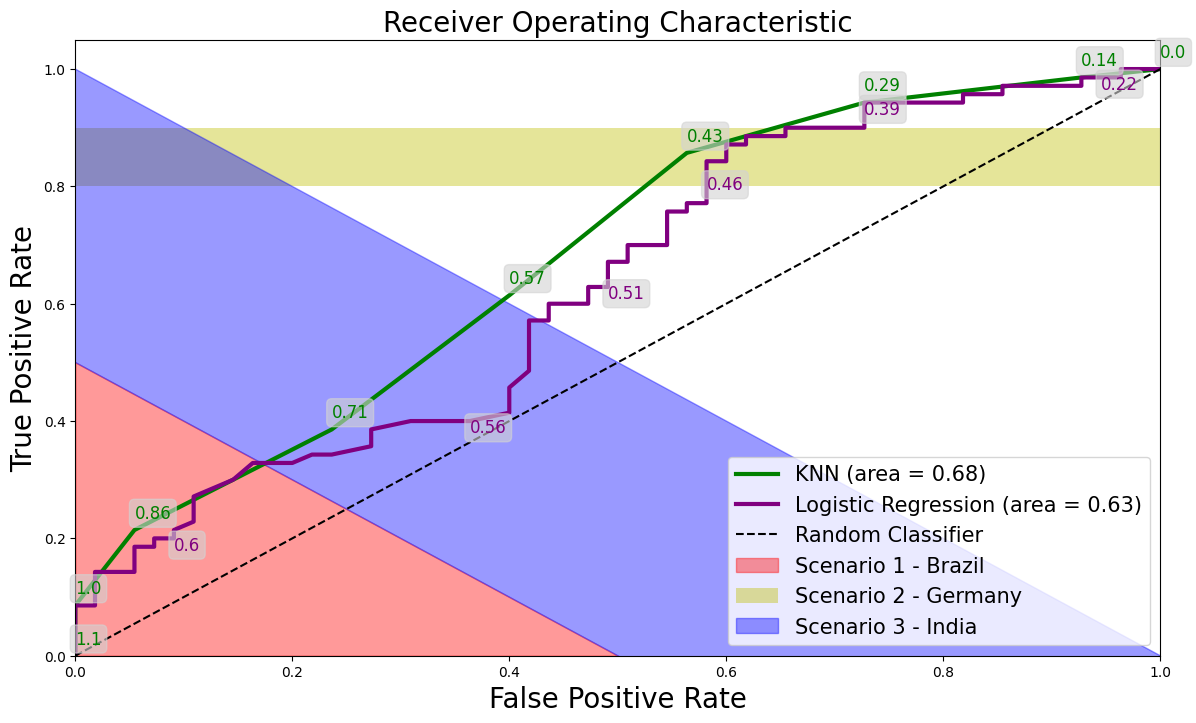

In [12]:
### edTest(test_plot) ###

# Area under curve - Logistic Regression & kNN
fig, ax = plt.subplots(figsize = (14,8))

# Plot KNN Regression ROC Curve
ax.plot(knn_fpr,
        knn_tpr,
        label=f'KNN (area = {knn_auc:.2f})',
        color='g',
        lw=3)

# Plot Logistic Regression ROC Curve
ax.plot(logreg_fpr,
        logreg_tpr,
        label=f'Logistic Regression (area = {logreg_auc:.2f})',
        color = 'purple',
        lw=3)

# Threshold annotations
label_kwargs = {}
label_kwargs['bbox'] = dict(
    boxstyle='round, pad=0.3', color='lightgray', alpha=0.6
)
eps = 0.02 # offset
for i in range(0, len(logreg_fpr),15):
    threshold = str(np.round(logreg_thresholds[i], 2))
    ax.annotate(threshold, (logreg_fpr[i], logreg_tpr[i]-eps), fontsize=12, color='purple', **label_kwargs)

for i in range(0, len(knn_fpr)-1):
    threshold = str(np.round(knn_thresholds[i], 2))
    ax.annotate(threshold, (knn_fpr[i], knn_tpr[i]+eps), fontsize=12, color='green', **label_kwargs)

# Plot diagonal line representing a random classifier
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Scenario 1 - Brazil
ax.fill_between([0,0.5],[0.5,0], color = 'red', alpha = 0.4, label='Scenario 1 - Brazil');

# Scenario 2 - Germany
ax.axhspan(0.8, 0.9, facecolor='y', alpha=0.4, label = 'Scenario 2 - Germany');

# Scenario 3 - India
ax.fill_between([0,1],[1,0],[0.5,-0.5], alpha = 0.4, color = 'blue', label = 'Scenario 3 - India');

ax.set_xlim([0.0, 1.0]);
ax.set_ylim([0.0, 1.05]);
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('Receiver Operating Characteristic', fontsize=20)
ax.legend(loc="lower right", fontsize=15)
plt.show()